In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
XCr_path = os.getcwd()+'/../'
sys.path.append(XCr_path)
from XCrystal import *
t0 = time.time()

## Loading XCrystal configuration

In [2]:
omega= 17450.0
xcr = XCrystal(XCr_path+'/config/Si440_17p45keVDislk60degGronkowskiFiniteCrystal3D.yaml',omega)
pp=xcr.configure(0,0)
pp

Geometry file was provided


## Defining single realization reflection object

In [3]:

def single_realization_with_data(delta_theta,Rock_angle):
    
    xcr = XCrystal(XCr_path+'/config/Si440_17p45keVDislk60degGronkowskiFiniteCrystal3D.yaml',omega)
    xcr.configure(delta_theta,Rock_angle)
    xcr.run3D()
    return xcr.Reflectivity, xcr.Transmission, xcr.U1_field, xcr.U2_field, xcr.u, xcr.M

In [4]:
omega0=17450

## Running beam propagation

In [5]:
U1_data = []
U2_data = []

Rs, Ts, U1_xyz, U2_xyz, up, MM = single_realization_with_data(1.0e-7,omega0)
U1_data.append(U1_xyz)
U2_data.append(U2_xyz)

U1_xyz = np.asarray(U1_data)
U2_xyz = np.asarray(U2_data)

Geometry file was provided


Beam propagation progress: 100%|██████████| 300/300 [00:08<00:00, 35.97it/s]


Photon energy (omega):  17450.0 ; Reflectivity:  0.024012654881508434 ; Transmission:  0.9707145548209176


In [6]:
t1 = time.time()  
print('Time (sec):', (t1 - t0))

Time (sec): 10.16839861869812


## Determining relative phase between reflected and transmitted fields

In [7]:
ket12=np.sum(np.sum(U1_xyz[0,:,:,:]*np.conj(U2_xyz[0,:,:,:]),axis=0),axis=0)
ket21=np.sum(np.sum(U2_xyz[0,:,:,:]*np.conj(U1_xyz[0,:,:,:]),axis=0),axis=0)+1e-30
thet=np.unwrap(np.angle(-ket12/ket21))

In [8]:
Ints=np.abs(U1_xyz[0,:,:,:] + U2_xyz[0,:,:,:]*np.exp(1j*thet/2))**2
Ints2=np.abs(U1_xyz[0,:,:,:]*0 + U2_xyz[0,:,:,:]*np.exp(1j*thet/2))**2
Ints1=np.abs(U1_xyz[0,:,:,:] + 0*U2_xyz[0,:,:,:]*np.exp(1j*thet/2))**2
SumInts=np.abs(U1_xyz[0,:,:,:])**2 + np.abs(U2_xyz[0,:,:,:])**2

## Displaying results

### Intensity in the $xy$-plane

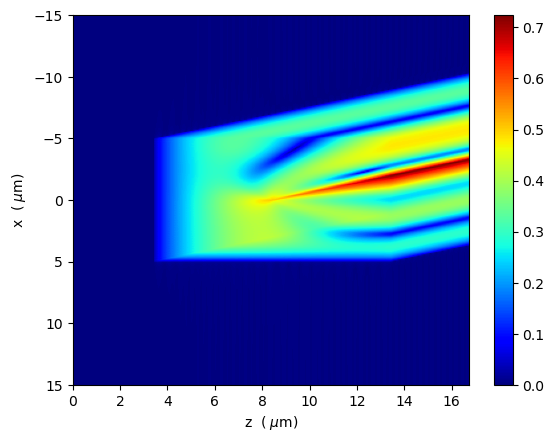

In [9]:
p=np.intc(np.rint(xcr.ygrid)/2)
wM=xcr.M-1
plt.imshow(Ints1[:,p,0:wM]**0.3,extent=[0,xcr.M*xcr.Z/xcr.convr*1e6,xcr.xx.max()/xcr.convr*1e6,-xcr.xx.max()/xcr.convr*1e6], aspect='auto',cmap='jet')
#plt.ylim(-10,10)
#plt.xlim(110,410)
plt.ylabel(r'x  ( $\mu$m)')
plt.xlabel(r'z  ( $\mu$m)')
plt.colorbar()

### Intensity in the $xy$-plane (corresponding to X-ray topography)

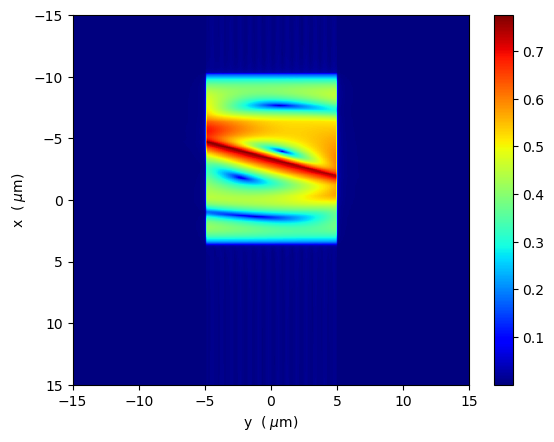

In [10]:
plt.imshow((Ints1[:,:,xcr.M-1])**0.25,extent=[-xcr.yy.max()/xcr.convr*1e6,xcr.yy.max()/xcr.convr*1e6,xcr.xx.max()/xcr.convr*1e6,xcr.xx.min()/xcr.convr*1e6], aspect='auto',cmap='jet')
plt.ylabel(r'x  ( $\mu$m)')
plt.xlabel(r'y  ( $\mu$m)')
plt.colorbar()
#plt.ylim(-20,100)
#plt.xlim(-60,60)

### Intensity in the $xy$-plane, 3D display

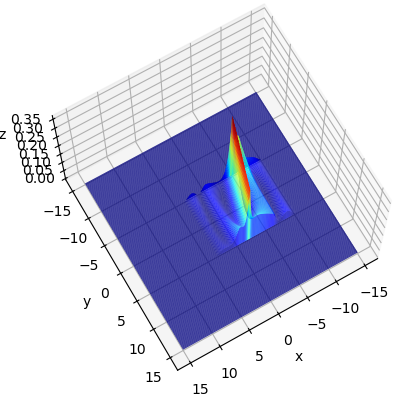

In [11]:
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')

Z=Ints1[:,:,xcr.M-1]
ax.plot_surface(xcr.Xx/xcr.convr*1e6,xcr.Yy/xcr.convr*1e6,Z, rstride=1, cstride=1,
                cmap='jet', edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');
ax.view_init(70, 60)



In [12]:
xcr.cr_mask.shape

(300, 200, 300)

## 

In [13]:
xcr.xx.shape

(300,)

## Propagating to the detector position using the Fresnel method

#### Propagation distance Lm [m]

In [14]:
Lm=4

In [15]:
L=Lm*xcr.convr

In [16]:
a= U1_xyz[0,:,:,xcr.M-1]
a=np.pad(a, ((450,450), (300,300)), 'constant', constant_values=(0.0 + 1j*0.0, 0.0 + 1j*0.0))
dxx=xcr.xx[1]-xcr.xx[0]
dyy=xcr.yy[1]-xcr.yy[0]
xxp = dxx*(np.arange(1,a.shape[0]+1) - 0.5*(a.shape[0]))
yyp = dyy*(np.arange(1,a.shape[1]+1) - 0.5*(a.shape[1]))
xxp.shape
xcr.xx.shape
yyp.shape
Yyp, Xxp = np.meshgrid(yyp,xxp) # x,y mesh/grid
dxf_out = 2*np.pi*L/(dxx*a.shape[0])
dyf_out = 2*np.pi*L/(dyy*a.shape[1])
xxp_out = dxf_out*(np.arange(1,a.shape[0]+1) - 0.5*(a.shape[0]))
yyp_out = dyf_out*(np.arange(1,a.shape[1]+1) - 0.5*(a.shape[1]))
Yyp_out, Xxp_out = np.meshgrid(yyp_out,xxp_out) # x,y mesh/grid
r_out_sq=Yyp_out**2+ Xxp_out**2 
Yyp.shape

(1200, 800)

### Intensity at the distance 4 m form the crystal

Text(0.5, 1.0, 'Intensity at the distance 4 m form the crystal')

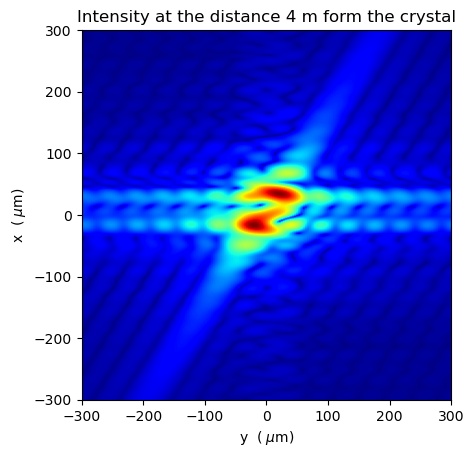

In [17]:
r_sq=Xxp**2+Yyp**2
G11 = np.fft.fftshift(np.fft.fft2(a*np.exp(1j/2*r_sq/L)), axes=(0,1))
U1_xy_out=G11*np.exp((1j/2)* r_out_sq/L)*(-1j)*dxx*dyy/(2*np.pi*L)
plt.imshow((np.abs(U1_xy_out)**0.5),extent=[xxp_out.min()/xcr.convr*1e6,xxp_out.max()/xcr.convr*1e6,yyp_out.min()/xcr.convr*1e6,yyp_out.max()/xcr.convr*1e6],cmap='jet')
plt.ylim(-300,300)
plt.xlim(-300,300)
plt.xlabel(r'y  ( $\mu$m)')
plt.ylabel(r'x  ( $\mu$m)')
plt.title('Intensity at the distance 4 m form the crystal')

## Displaying distribution of displacement component $u_x$

Text(0.5, 1.0, 'u_x(x,z)')

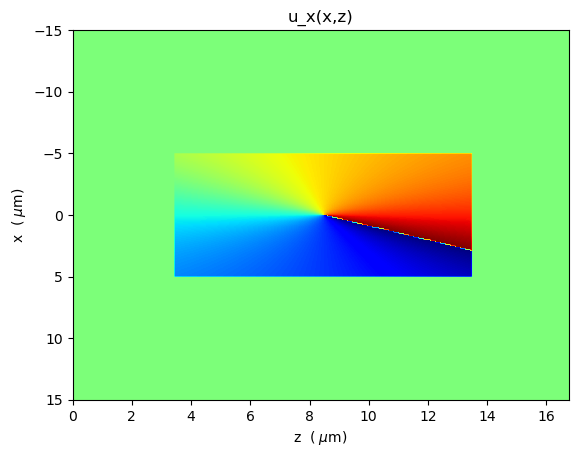

In [18]:
plt.imshow(xcr.u[:,p,0:wM]*xcr.cr_mask[:,p,0:wM],extent=[0,xcr.M*xcr.Z/xcr.convr*1e6,xcr.xx.max()/xcr.convr*1e6,-xcr.xx.max()/xcr.convr*1e6], aspect='auto',cmap='jet')
#plt.ylim(-10,10)
#plt.xlim(22,34)
plt.ylabel(r'x  ( $\mu$m)')
plt.xlabel(r'z  ( $\mu$m)')
plt.title('u_x(x,z)')

In [19]:
xcr.u.shape

(300, 200, 300)

In [20]:
px=200
py=100
pz=250

Text(0.5, 1.0, 'u_x(y,z)')

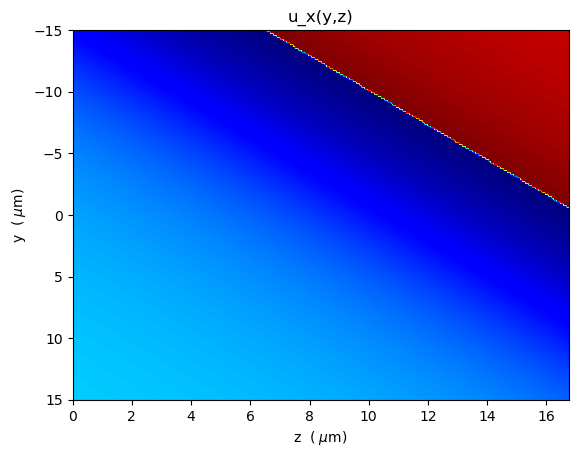

In [21]:
plt.imshow(xcr.u[px,:,:],extent=[0,xcr.M*xcr.Z/xcr.convr*1e6,xcr.yy.max()/xcr.convr*1e6,-xcr.yy.max()/xcr.convr*1e6], aspect='auto',cmap='jet')
plt.ylabel(r'y  ( $\mu$m)')
plt.xlabel(r'z  ( $\mu$m)')
plt.title('u_x(y,z)')

Text(0.5, 1.0, 'u_x(x,y)')

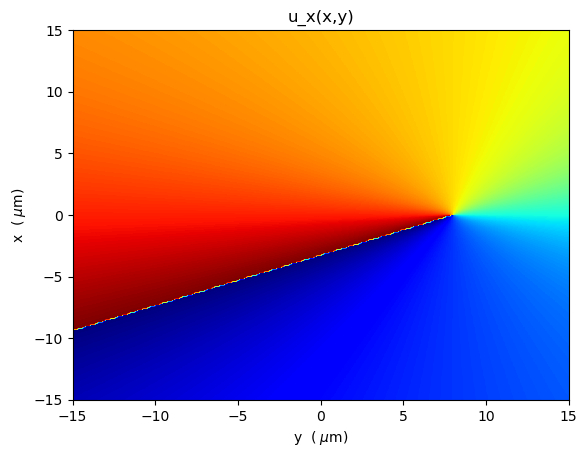

In [22]:
plt.imshow(xcr.u[:,:,pz],extent=[-xcr.yy.max()/xcr.convr*1e6,xcr.yy.max()/xcr.convr*1e6,-xcr.xx.max()/xcr.convr*1e6,xcr.xx.max()/xcr.convr*1e6], aspect='auto',cmap='jet')
plt.ylabel(r'x  ( $\mu$m)')
plt.xlabel(r'y  ( $\mu$m)')
plt.title('u_x(x,y)')

In [23]:
t2 = time.time()  
print('Time (sec):', (t2 - t0))

Time (sec): 16.482433080673218


In [24]:
xcr.zsep

1